# Format Results

In [26]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# retain_results = "results/knowundo-copyright/qwen2-1.5b_retain_knowundo-copyright_checkpoint-347_noLORA_1e-04_10_0.01_retention_unlearn_seed42.csv"
# retain_results = "results/qwen2-1.5b/tofu-800/qwen2-1.5b_retain_tofu-800_checkpoint-237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv"
retain_results = "results/qwen2-1.5b/tofu-4000/qwen2-1.5b_retain_tofu-4000_checkpoint-1237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv"
# retain_results = "results/phi/tofu-4000/phi_retain_tofu-4000_checkpoint-1237_noLORA_5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv"
df_retain = pd.read_csv(retain_results)

# full_results = "results/knowundo-copyright/qwen2-1.5b_full_knowundo-copyright_checkpoint-496_noLORA_1e-04_10_0.01_full_unlearn_seed42.csv"
# full_results = "results/qwen2-1.5b/tofu-800/qwen2-1.5b_full_tofu-800_checkpoint-250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv"
full_results = "results/qwen2-1.5b/tofu-4000/qwen2-1.5b_full_tofu-4000_checkpoint-1250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv"
# full_results = "results/phi/tofu-4000/phi_full_tofu-4000_checkpoint-1250_noLORA_5e-05_10_0.01_full_forget01_perturbed_seed42.csv"
df_full = pd.read_csv(full_results)

In [28]:
def get_results(exp_name, df_full):
    folder = exp_name
    files = os.listdir(folder)
    files = [f for f in files if re.match(r".*\.csv", f)]
    df = pd.DataFrame()
    for f in files:
        pth = os.path.join(folder, f)
        tmp = pd.read_csv(pth)
        # replace "Method" column with layer.#
        step_num = tmp['Method'].values[0].split("_")[1].split("-")[1]
        layer_num = tmp['Method'].values[0].split("_")[8].split(".")[1]
        tmp['Step'] = step_num
        tmp['Layer'] = layer_num
        df = pd.concat([df, tmp])
    df['Step'] = df['Step'].astype(int)
    df['Layer'] = df['Layer'].astype(int)

    # add a df_full row for each layer
    layers = df['Layer'].unique()
    df_full_duplicated = pd.DataFrame([df_full.iloc[0]] * len(layers))
    df_full_duplicated['Layer'] = layers
    df_full_duplicated['Step'] = 0
    df = pd.concat([df, df_full_duplicated], ignore_index=True)
    df = df.sort_values(by=['Layer', 'Step']).reset_index(drop=True)

    return df

In [31]:
# results = "results/qwen2-1.5b/tofu-800/PFpL_5e-05_grad-ascent"
# results = "results/qwen2-1.5b/tofu/PFpL_5e-05_grad-ascent"
results = "results/qwen2-1.5b/tofu/PFpL_5e-05_grad-ascent_sophiag"
# results = "results/phi/tofu-4000/PFpL_5e-05_grad-ascent"
results_df = get_results(results, df_full)
if "tofu" in results:
    checkpoint_step = 2 # tofu
elif "knowundo" in results:
    checkpoint_step = 29 # knowundo

len(results_df)

308

In [22]:
def plot_PF(results, full_results, retain_results, save=None, default_zoom=False, figsize=(12,12), xlim=(1, 0.2), ylim=(0.2, 1), legend_loc='lower left'):
    df_full = pd.read_csv(full_results)
    df_retain = pd.read_csv(retain_results)
    df = get_results(results, df_full)

    if "tofu" in results:
        checkpoint_step = 2 # tofu
    elif "knowundo" in results:
        checkpoint_step = 21 # knowundo

    def best_step(experiment):
        # find the closest step to the ideal values
        df = experiment
        diff_retain = abs(df['ROUGE Retain'] - df_retain['ROUGE Retain'].values[0]) ** 2
        diff_forget = abs(df['ROUGE Forget'] - df_retain['ROUGE Forget'].values[0]) ** 2
        diff = np.sqrt(diff_retain + diff_forget)
        idx = diff.idxmin()
        return int(df.loc[idx]['Step'])

    fig, ax = plt.subplots(figsize=figsize)

    alpha = 0.5
    palette = sns.color_palette("coolwarm", 28) # hls, husl, coolwarm
    phi_palette = sns.color_palette("coolwarm", 24) # hls, husl, coolwarm

    for i, layer in enumerate(df['Layer'].dropna().unique()):
        if "/phi/" in results:
            if i > 23:
                break
            color = phi_palette[layer]
        else:
            color = palette[layer]
        layer_df = df[df['Layer'] == layer].reset_index(drop=True)
        sns.lineplot(x="ROUGE Forget", y="ROUGE Retain", data=layer_df, ax=ax, marker="o", c=color, alpha=alpha, label=f"Layer {layer}")
        step = best_step(layer_df)
        text_x = layer_df["ROUGE Forget"][step//checkpoint_step] - 0.0015
        text_y = layer_df["ROUGE Retain"][step//checkpoint_step] - 0.0015
        ax.annotate(f"{layer}", (text_x, text_y), fontsize=10, color=color, alpha=1, clip_on=True, zorder=2)

    sns.scatterplot(x="ROUGE Forget", y="ROUGE Retain", data=df_retain, ax=ax, marker="*", s=300, c="b", alpha=1, zorder=2, label="Retain")

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(loc=legend_loc)

    if default_zoom:
        plt.xlim(0.55, 0.35)
        plt.ylim(0.8, 1)
        plt.legend(loc='lower right')

    plt.show()

    # save
    if save:
        fig.savefig(save, format='svg', bbox_inches='tight')

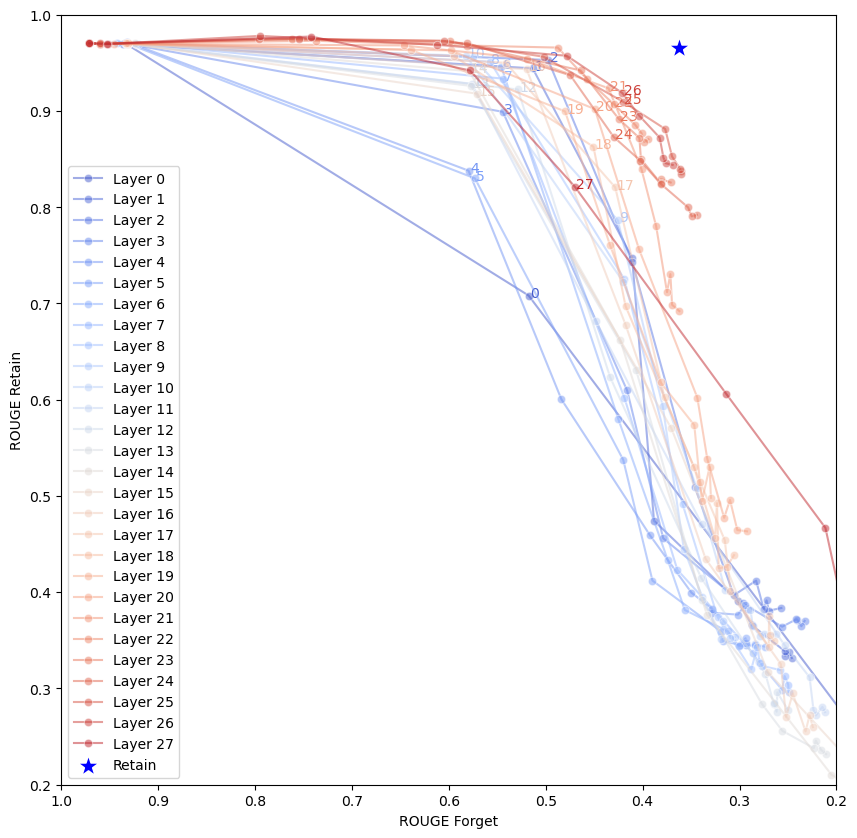

In [23]:
plot_PF(
    # results="results/qwen2-1.5b/tofu-800/PFpL_3e-05_grad-ascent",
    results="results/qwen2-1.5b/tofu-800/PFpL_5e-05_grad-ascent",
    full_results="results/qwen2-1.5b/tofu-800/qwen2-1.5b_full_tofu-800_checkpoint-250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv",
    retain_results="results/qwen2-1.5b/tofu-800/qwen2-1.5b_retain_tofu-800_checkpoint-237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv",
    figsize=(10,10),
    # default_zoom=True,
    # xlim=(0.55, 0.35),
    # ylim=(0.8, 1),
    # legend_loc="lower left",
    # save="figures/PFpL_qwen_tofu800_GA_adamw.svg",
)

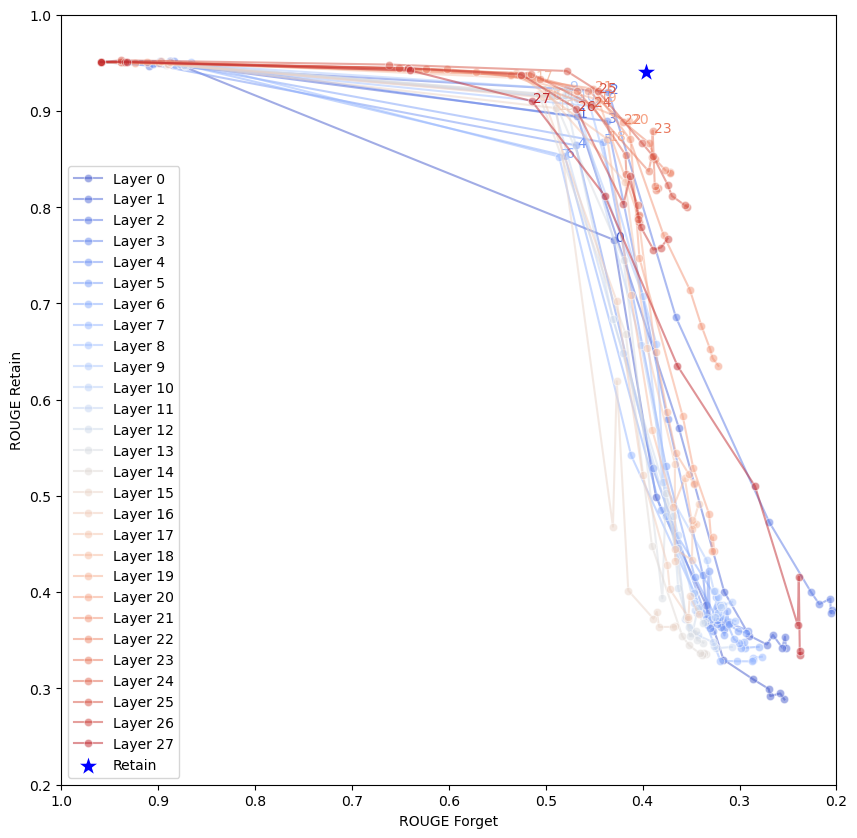

In [14]:
plot_PF(
    results="results/qwen2-1.5b/tofu/PFpL_5e-05_grad-ascent_sophiag",
    full_results="results/qwen2-1.5b/tofu-4000/qwen2-1.5b_full_tofu-4000_checkpoint-1250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv",
    retain_results="results/qwen2-1.5b/tofu-4000/qwen2-1.5b_retain_tofu-4000_checkpoint-1237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv",
    figsize=(10,10),
    # default_zoom=True,
    # xlim=(0.55, 0.35),
    # ylim=(0.8, 1),
    # legend_loc="lower left",
    # save="figures/PFpL_qwen_tofu4000_GA_sophiag.svg",
)

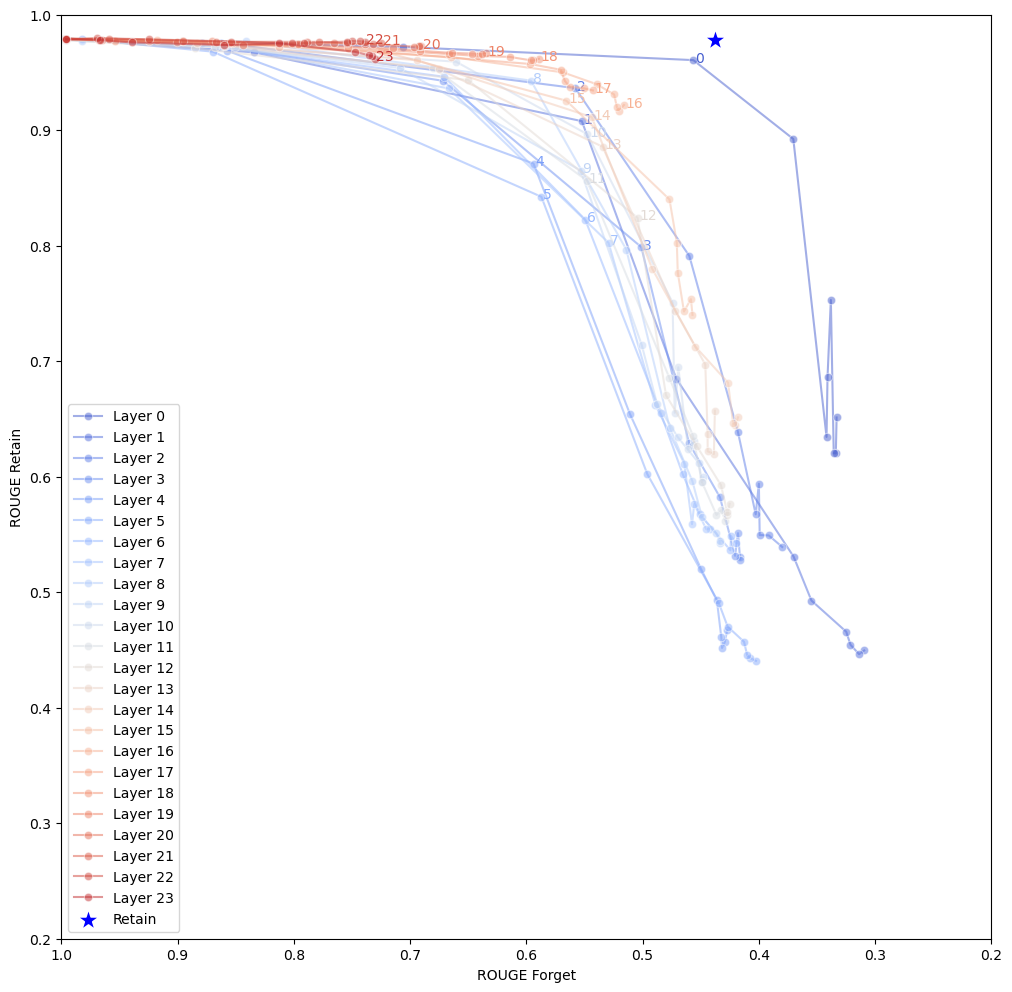

In [25]:
plot_PF(
    results="results/phi/tofu-4000/PFpL_5e-05_grad-ascent",
    full_results="results/phi/tofu-4000/phi_full_tofu-4000_checkpoint-1250_noLORA_5e-05_10_0.01_full_forget01_perturbed_seed42.csv",
    retain_results="results/phi/tofu-4000/phi_retain_tofu-4000_checkpoint-1237_noLORA_5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv",
    # default_zoom=True,
    # xlim=(0.55, 0.35),
    # ylim=(0.8, 1),
    # legend_loc="lower left",
    # save="figures/PFpL_phi_tofu4000_GA_sophia.svg",
)

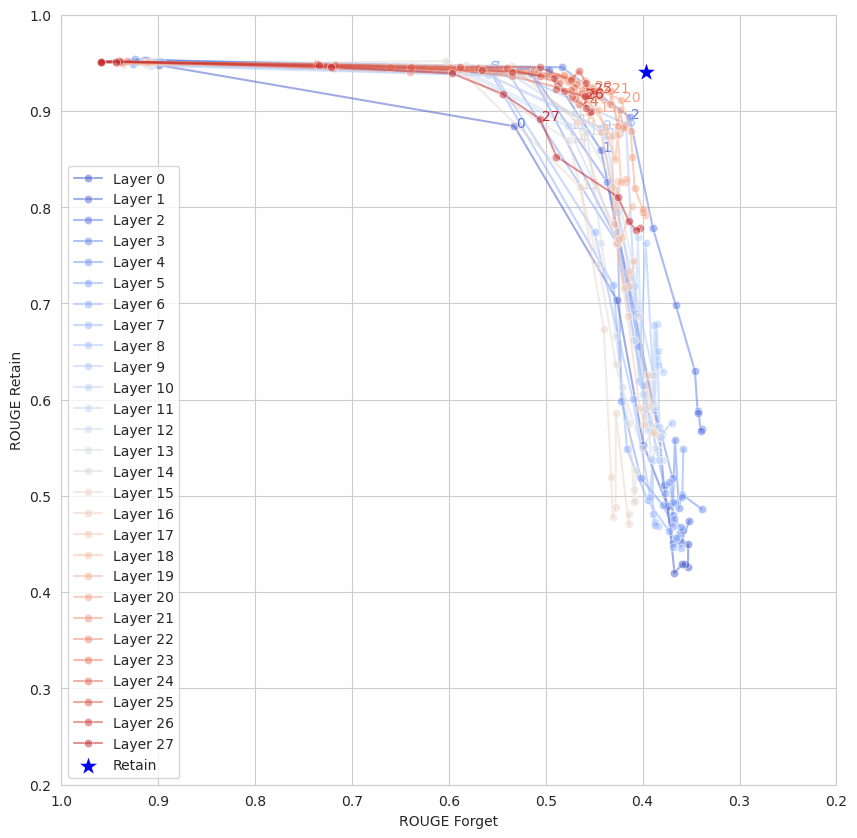

In [36]:
plot_PF(
    results="results/qwen2-1.5b/tofu/PFpL_5e-05_grad-ascent_adamw",
    full_results="results/qwen2-1.5b/tofu-4000/qwen2-1.5b_full_tofu-4000_checkpoint-1250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv",
    retain_results="results/qwen2-1.5b/tofu-4000/qwen2-1.5b_retain_tofu-4000_checkpoint-1237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv",
    figsize=(10,10),
    # default_zoom=True,
    # xlim=(0.55, 0.35),
    # ylim=(0.8, 1),
    # legend_loc="lower left",
    # save="figures/PFpL_qwen_tofu4000_GA_adamw.svg",
    # save="figures/PFpL_tofu4000_GA_adamw_noDS.svg",
)

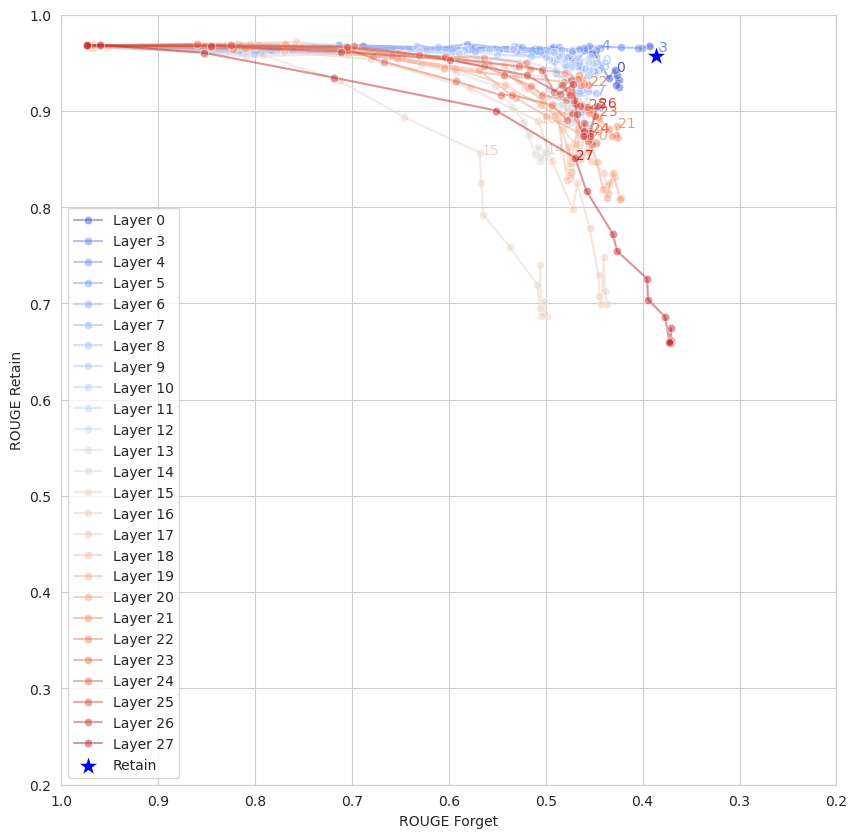

In [35]:
plot_PF(
    results="results/qwen2-1.5b/tofu/PFpL_5e-05_grad-ascent_mod",
    full_results="results/qwen2-1.5b/tofu/qwen2-1.5b_ft_DS_noLORA_lr1.5e-05_checkpoint-625_full_forget01_perturbed.csv",
    retain_results="results/qwen2-1.5b/tofu/qwen2-1.5b_ft_DS_noLORA_lr1.5e-05_checkpoint-618_retain99_forget01_perturbed.csv",
    figsize=(10,10),
    # default_zoom=True,
    # xlim=(0.55, 0.35),
    # ylim=(0.8, 1),
    # legend_loc="lower left",
    # save="figures/PFpL_tofu4000_GA_adamw_DS.svg",
)

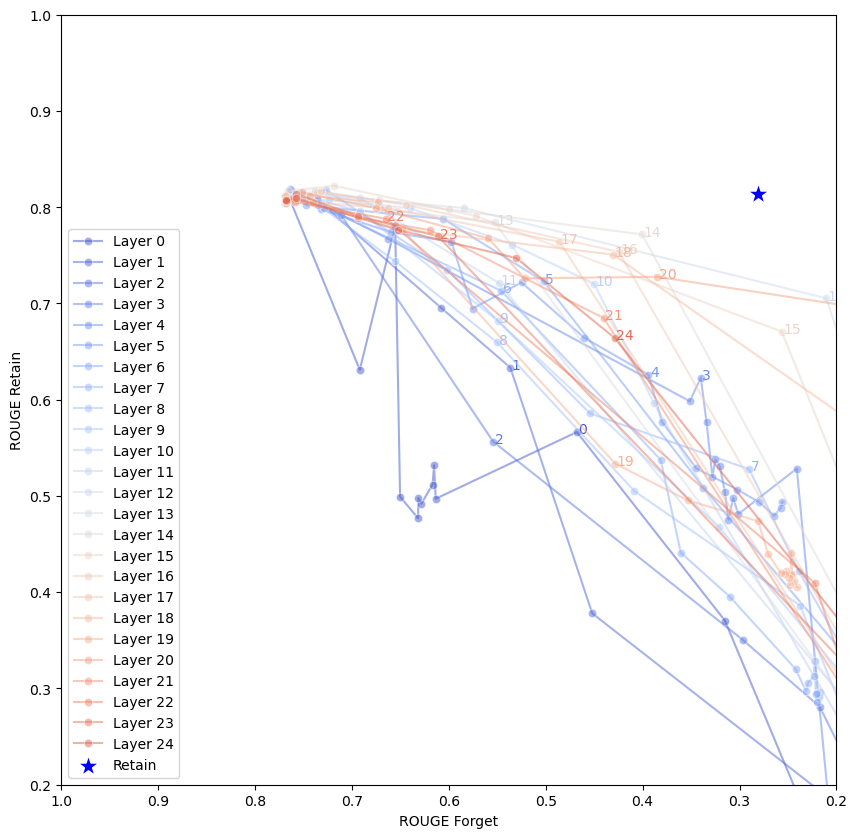

In [54]:
plot_PF(
    results="results/qwen2-1.5b/knowundo-copyright/pareto_frontier_per_layer_3e-05_grad-ascent",
    full_results="results/qwen2-1.5b/knowundo-copyright/qwen2-1.5b_full_knowundo-copyright_checkpoint-496_noLORA_1e-04_10_0.01_full_unlearn_seed42.csv",
    retain_results="results/qwen2-1.5b/knowundo-copyright/qwen2-1.5b_retain_knowundo-copyright_checkpoint-347_noLORA_1e-04_10_0.01_retention_unlearn_seed42.csv",
    figsize=(10,10),
    # default_zoom=True,
    # xlim=(1, 0),
    # ylim=(0, 1),
    # legend_loc="lower left",
    save="figures/PFpL_qwen_knowundo_GA.svg",
)

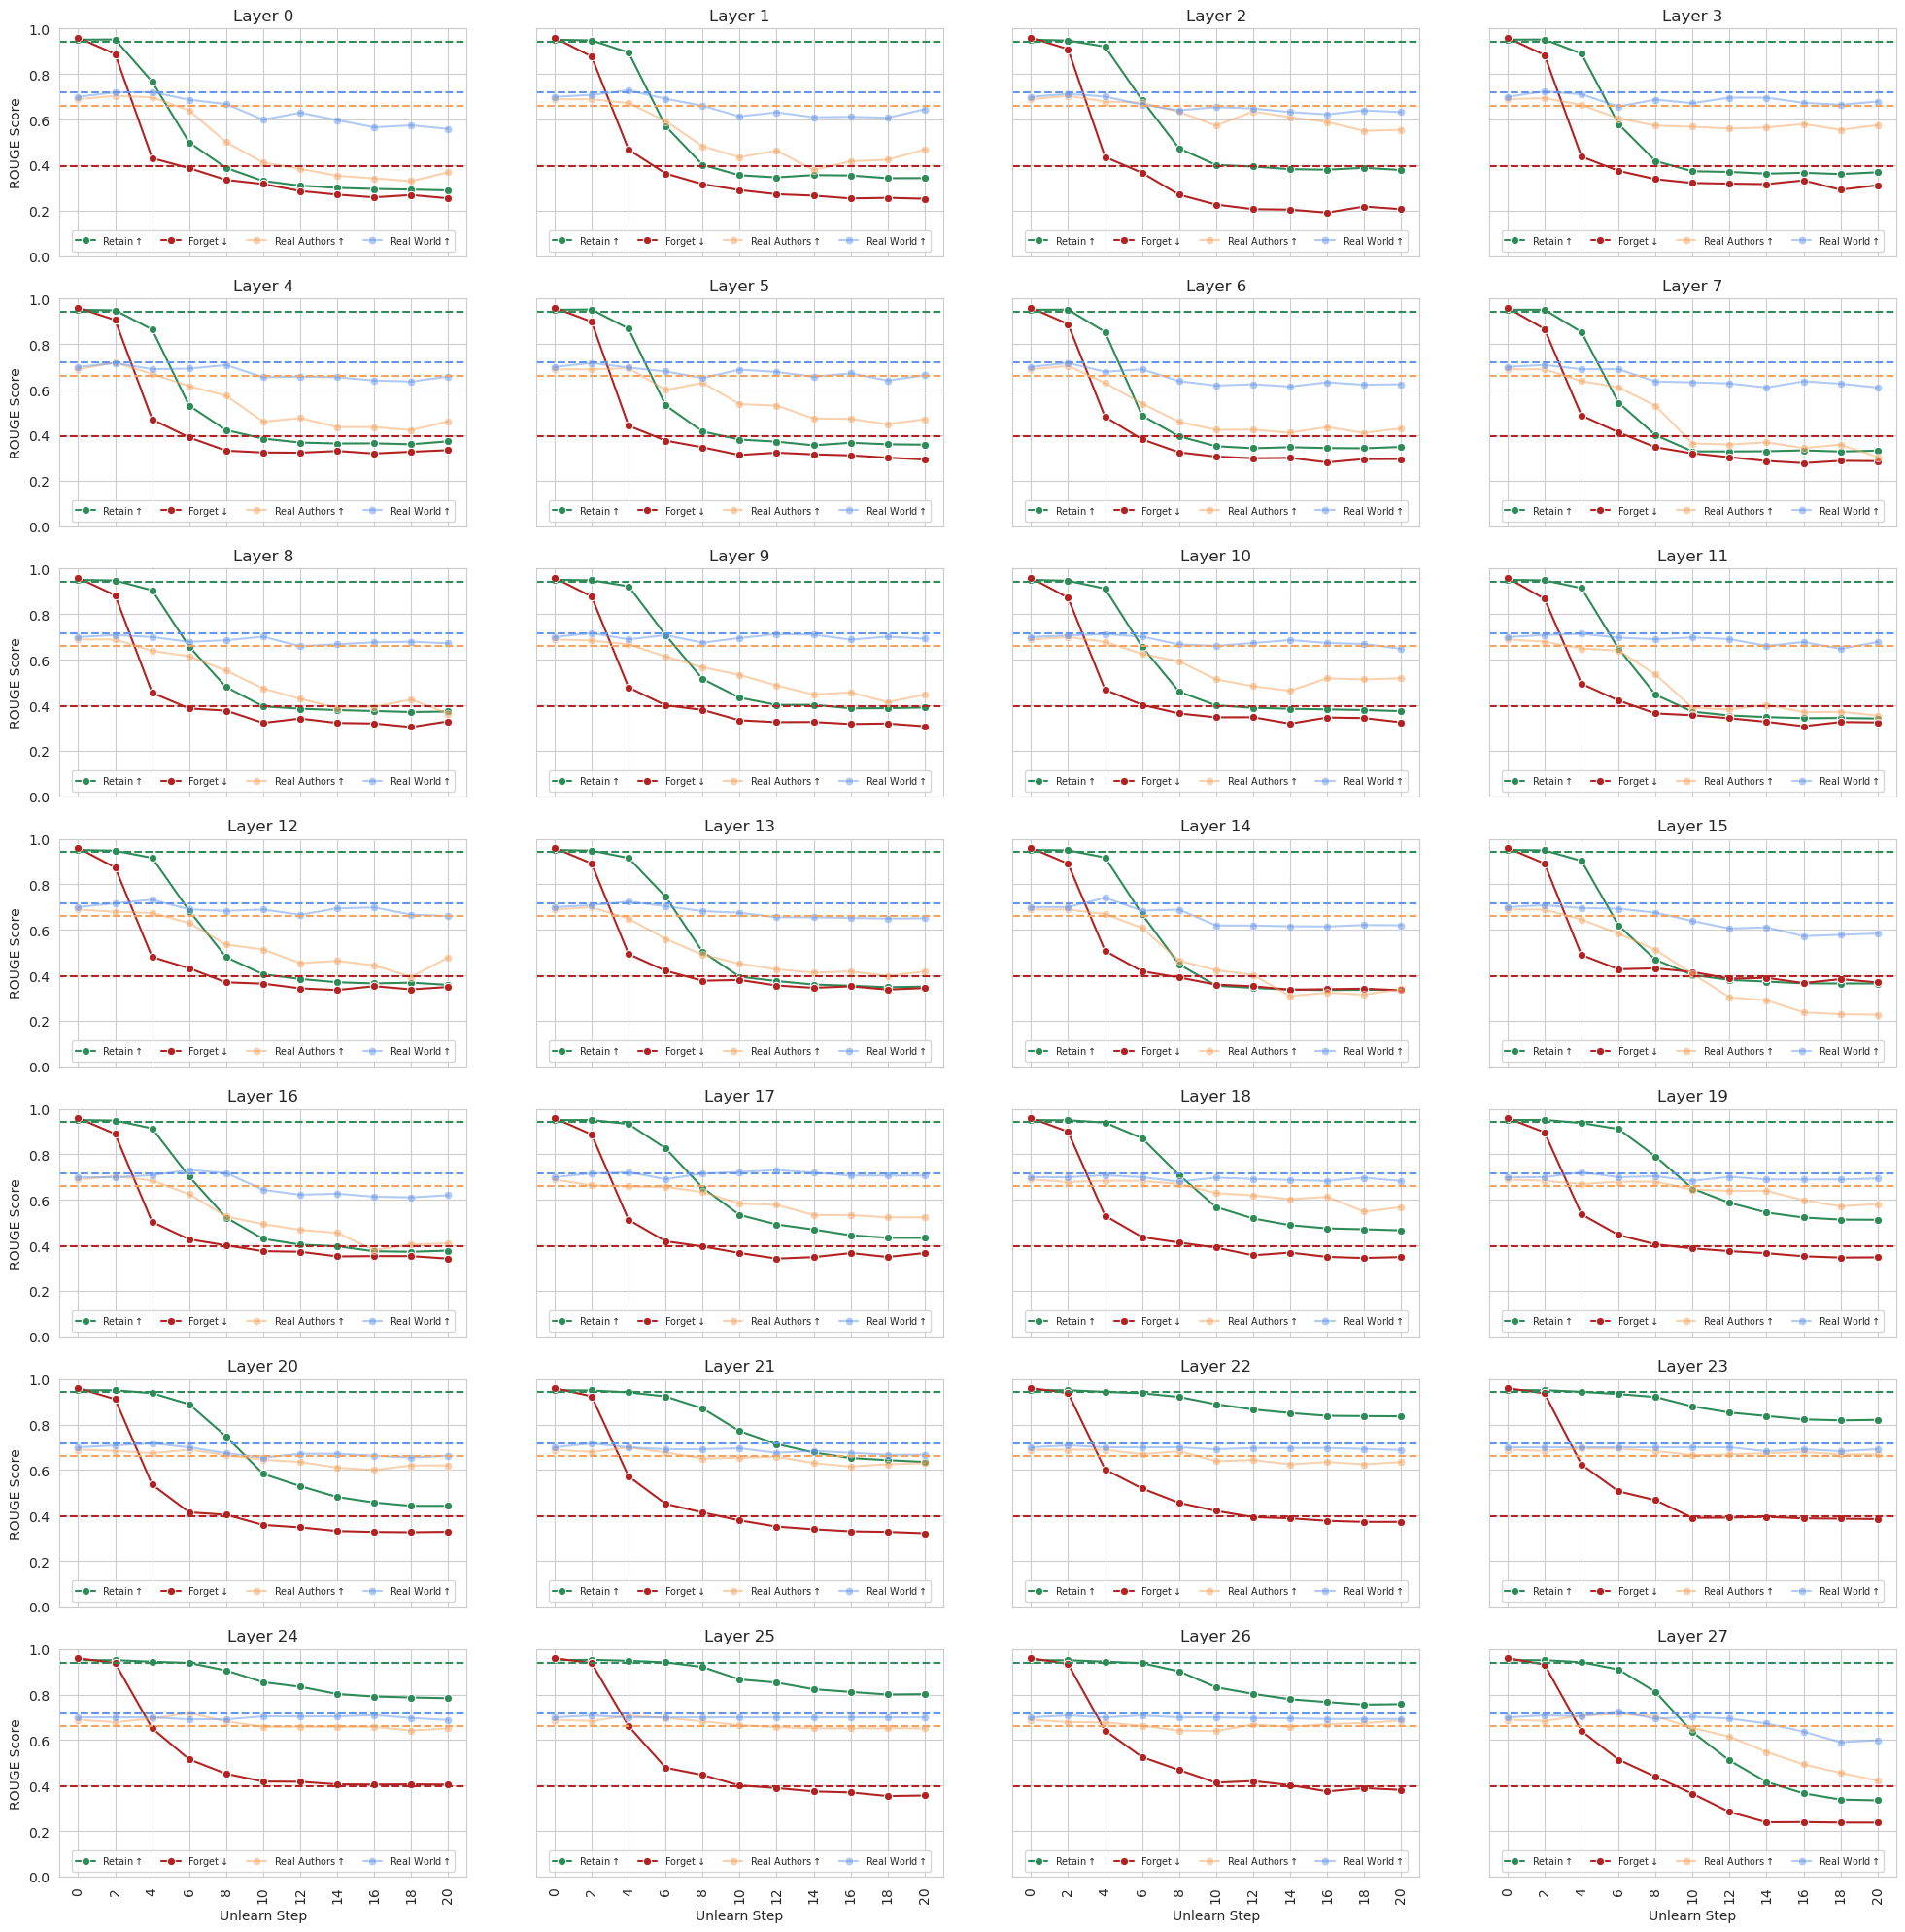

In [33]:
# create a plot for the trajectory of each layer over steps in a large plot with 28 subplots
sns.set_style(style="whitegrid")

fig, axs = plt.subplots(7, 4, figsize=(20, 20), sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    layer_idx = i
    df_ = results_df[results_df['Layer'] == layer_idx].reset_index(drop=True)
    sns.lineplot(x="Step", y="ROUGE Retain", data=df_, ax=ax, marker="o", label="Retain$\\uparrow$", c="seagreen", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Forget", data=df_, ax=ax, marker="o", label="Forget$\\downarrow$", c="firebrick", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Real Authors", data=df_, ax=ax, marker="o", label="Real Authors$\\uparrow$", c="sandybrown", alpha=0.5)
    sns.lineplot(x="Step", y="ROUGE Real World", data=df_, ax=ax, marker="o", label="Real World$\\uparrow$", c="cornflowerblue", alpha=0.5)

    # plot horizontal line for retain rouge and forget rouge
    ax.axhline(y=df_retain['ROUGE Retain'].values[0], color='seagreen', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Forget'].values[0], color='firebrick', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Real Authors'].values[0], color='sandybrown', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Real World'].values[0], color='cornflowerblue', linestyle='--')

    #change x axis name
    ax.set_xlabel("Unlearn Step")
    ax.set_ylabel("ROUGE Score")

    ax.legend(loc='lower center', ncols=4, prop={'size': 7})

    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=90)

    if "tofu" in results:
        ax.set_xticks(np.arange(0, 21, 2))
    elif "knowundo" in results:
        ax.set_xticks(np.arange(0, 358, 17))

    ax.set_title(f"Layer {layer_idx}")

plt.tight_layout()
plt.show()

# fig.savefig("figures/PFpL_qwen_tofu4000_GA_sophiag_chart.svg", format="svg", bbox_inches='tight')

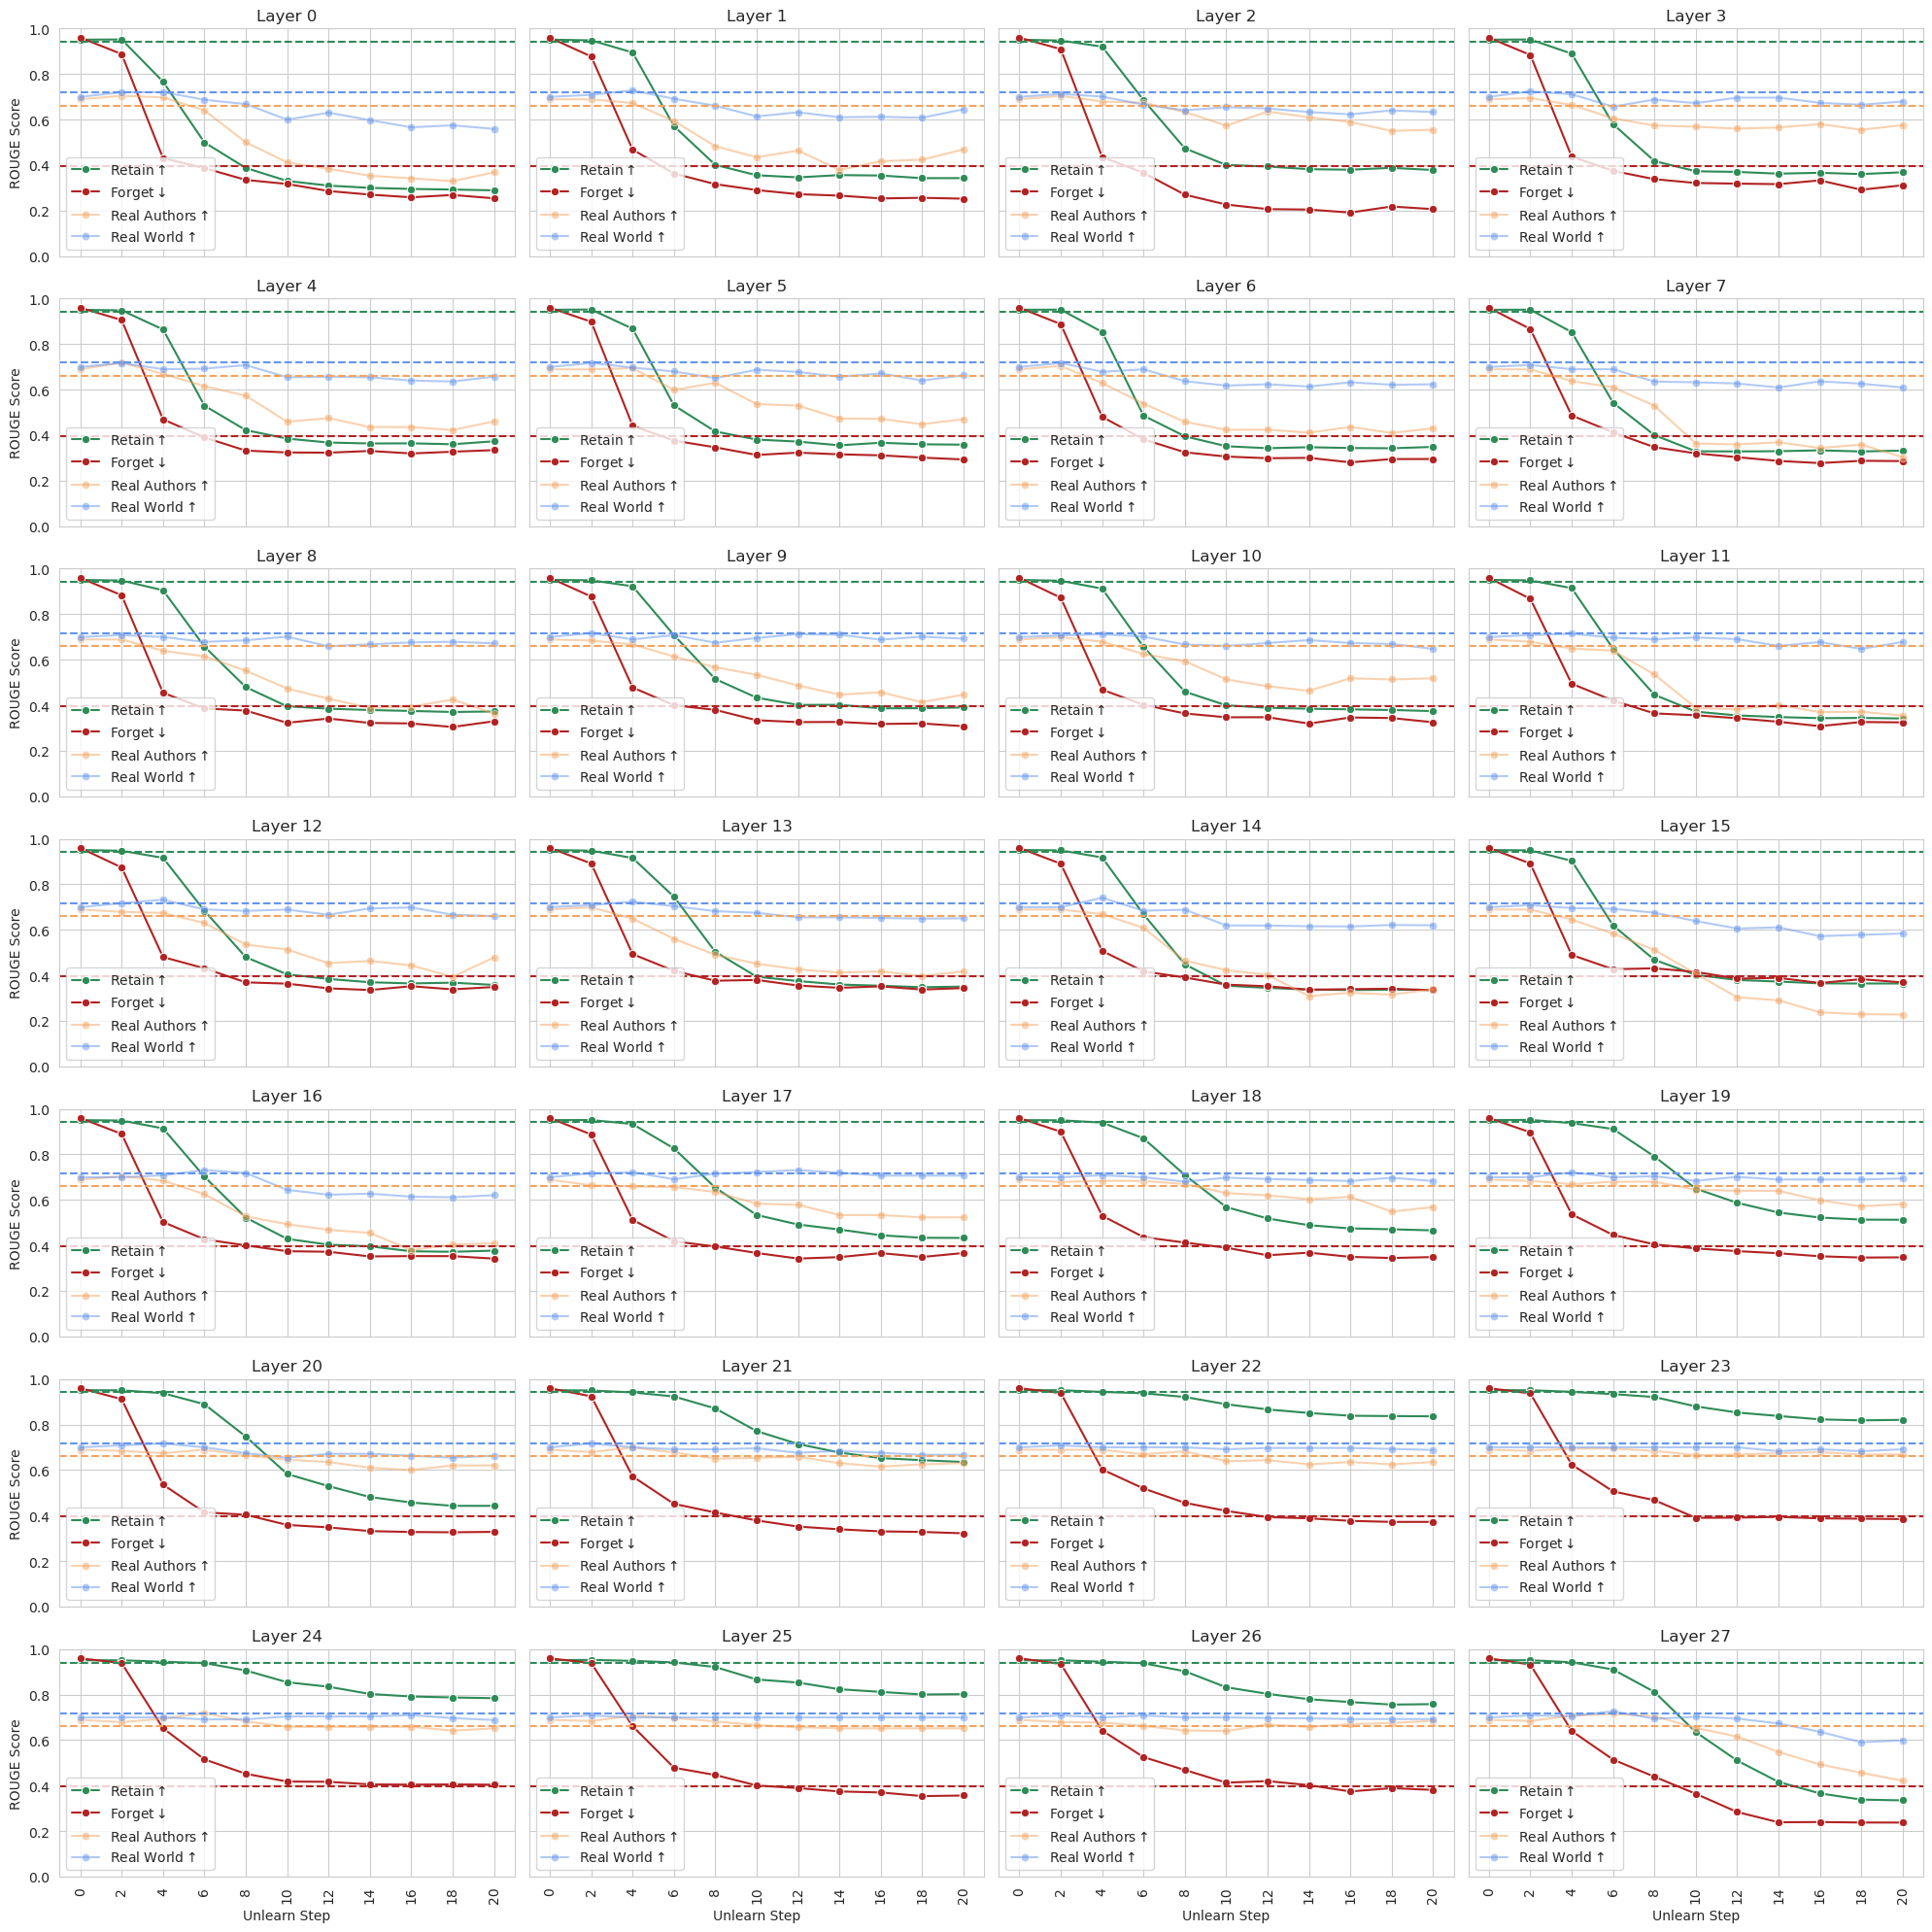

In [29]:
# create a plot for the trajectory of each layer over steps in a large plot with 28 subplots
sns.set_style(style="whitegrid")

fig, axs = plt.subplots(7, 4, figsize=(20, 20), sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    layer_idx = i
    df_ = results_df[results_df['Layer'] == layer_idx].reset_index(drop=True)
    sns.lineplot(x="Step", y="ROUGE Retain", data=df_, ax=ax, marker="o", label="Retain$\\uparrow$", c="seagreen", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Forget", data=df_, ax=ax, marker="o", label="Forget$\\downarrow$", c="firebrick", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Real Authors", data=df_, ax=ax, marker="o", label="Real Authors$\\uparrow$", c="sandybrown", alpha=0.5)
    sns.lineplot(x="Step", y="ROUGE Real World", data=df_, ax=ax, marker="o", label="Real World$\\uparrow$", c="cornflowerblue", alpha=0.5)

    # plot horizontal line for retain rouge and forget rouge
    ax.axhline(y=df_retain['ROUGE Retain'].values[0], color='seagreen', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Forget'].values[0], color='firebrick', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Real Authors'].values[0], color='sandybrown', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Real World'].values[0], color='cornflowerblue', linestyle='--')

    #change x axis name
    ax.set_xlabel("Unlearn Step")
    ax.set_ylabel("ROUGE Score")

    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=90)

    if "tofu" in results:
        ax.set_xticks(np.arange(0, 21, 2))
    elif "knowundo" in results:
        ax.set_xticks(np.arange(0, 358, 17))

    ax.set_title(f"Layer {layer_idx}")

plt.tight_layout()
plt.show()

# fig.savefig("figures/pareto_frontier_3e-05_grad-ascent_sharedaxis_knowundo.svg", format="svg")

In [ ]:
# plot each layer on the x axis and both the retain rouge and forget rouge on the y axis
sns.set_style(style="whitegrid")

layer_idx = 3

df_ = results_df[results_df['Layer'] == layer_idx].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(x="Step", y="ROUGE Retain", data=df_, ax=ax, marker="o", label="Retain$\\uparrow$", c="seagreen", alpha=1)
sns.lineplot(x="Step", y="ROUGE Forget", data=df_, ax=ax, marker="o", label="Forget$\\downarrow$", c="firebrick", alpha=1)
sns.lineplot(x="Step", y="ROUGE Real Authors", data=df_, ax=ax, marker="o", label="Real Authors$\\uparrow$", c="sandybrown", alpha=0.5)
sns.lineplot(x="Step", y="ROUGE Real World", data=df_, ax=ax, marker="o", label="Real World$\\uparrow$", c="cornflowerblue", alpha=0.5)

# plot horizontal line for retain rouge and forget rouge
ax.axhline(y=df_retain['ROUGE Retain'].values[0], color='seagreen', linestyle='--')
ax.axhline(y=df_retain['ROUGE Forget'].values[0], color='firebrick', linestyle='--')
ax.axhline(y=df_retain['ROUGE Real Authors'].values[0], color='sandybrown', linestyle='--')
ax.axhline(y=df_retain['ROUGE Real World'].values[0], color='cornflowerblue', linestyle='--')

#change x axis name
ax.set_xlabel("Unlearn Step")
ax.set_ylabel("ROUGE Score")

ax.set_ylim(0, 1)

if "tofu" in results:
    ax.set_xticks(np.arange(0, 32, 2))
elif "knowundo" in results:
    ax.set_xticks(np.arange(0, 358, 17))

# ax.get_legend().remove()

plt.show()

# save figure as svg
# fig.savefig(f"figures/{results_[r_idx]}.svg", format="svg")